In [1]:
# Importing dependencies
import imghdr
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyodbc
import urllib
import seaborn as sns; sns.set()
import six
import smtplib
import sqlalchemy
from dotenv import load_dotenv
from email.message import EmailMessage
from flask import Flask, jsonify, render_template
from flask_sqlalchemy import SQLAlchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, extract, func, inspect
from sqlalchemy import Column, Integer, Float, Date

In [2]:
# Loading cnxn_vars.env so that the environment variables can be used in the engine object url
load_dotenv("cnxn_vars.env")
# Initializing variables to hold each environmet varaible
uri=os.environ.get("URI")
email_addr=os.environ.get("SENDERADDRESS")
gmail_app_password=os.environ.get("GMAILAPPPASSWORD")
email_recipient=os.environ.get("EMAILRECIPIENT")
recipient_name=os.environ.get("RECIPIENTNAME")

In [3]:
# Creating an instance of the Flask class for the app
app = Flask(__name__)
#################################################
# Database Setup
#################################################
app.config["SQLALCHEMY_DATABASE_URI"] = uri
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
# Binding the instance of flask_sqlalchemy.SQLAlchemy to this specific flask app
db = SQLAlchemy(app)
# Initializing a variable with the created engine
engine = db.engine
# Initializing a variable with the connection resource
connection = engine.connect()
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [4]:
# Initializing a variable to hold the MetaData object
md = sqlalchemy.MetaData()
# InitialiZing a variable to hold the table metadata
PGEPublicElectric = sqlalchemy.Table('PGEPublicElectric', md, autoload=True, autoload_with=engine)
# Initializing a variable with the SQL query
stmt = db.session.query(PGEPublicElectric).\
    filter(PGEPublicElectric.c.ZipCode == 94105).\
    filter(PGEPublicElectric.c.CustomerClass == "Elec- Industrial").\
    filter(PGEPublicElectric.c.Year == 2019).\
    statement
# Initializing a variable to hold the base dataframe
base_df = pd.read_sql_query(stmt, db.session.bind).reset_index(drop=True)

In [5]:
base_df.sort_values("Month", ascending=True)

,ZipCode,Month,Year,CustomerClass,Combined,TotalkWh,AveragekWh,TotalCustomers
6,94105,1,2019,Elec- Industrial,Y,568035741,1159257.0,490
7,94105,2,2019,Elec- Industrial,Y,526927588,1053855.0,500
8,94105,3,2019,Elec- Industrial,Y,0,NaN,0
3,94105,4,2019,Elec- Industrial,Y,567094523,1125188.0,504
4,94105,5,2019,Elec- Industrial,Y,560538985,1215920.0,461
5,94105,6,2019,Elec- Industrial,Y,546897381,1196712.0,457
0,94105,7,2019,Elec- Industrial,Y,478223370,1255179.0,381
1,94105,8,2019,Elec- Industrial,Y,421568420,1368729.0,308
2,94105,9,2019,Elec- Industrial,Y,440049089,1282942.0,343


In [6]:
# Initializing a variable with the cleaned dataframe 
total_cust_df = base_df[["ZipCode", "Month", "TotalCustomers"]].sort_values("Month", ascending=True)

In [7]:
# Defining a function that will used the cleaned dataframe to render a more presentable looking table 
# that will be attached to the email
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

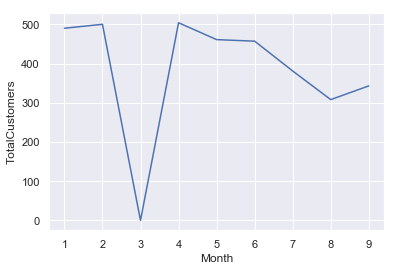

In [8]:
# Plotting the change in total customers for the 94105 zip code between 1/2019 and 9/2019
ax = sns.lineplot(x="Month", y="TotalCustomers", data=base_df)

In [9]:
# Initializing variables for use in testing the condition
start_month = min(base_df["Month"])
end_month = max(base_df["Month"])
start_tot_custs = l = list(base_df["TotalCustomers"][base_df["Month"] == start_month])[0]
end_tot_custs = l = list(base_df["TotalCustomers"][base_df["Month"] == end_month])[0]

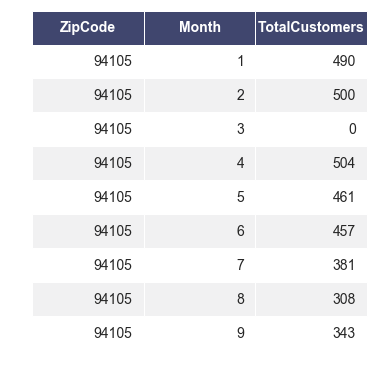

In [10]:
# Using a conditional statement to test whether the criteria under which an email must be sent has been met.
# In this case, the condition is that the number of customers has decrease by more than 10%
if (end_tot_custs - start_tot_custs < 0) and ((abs(end_tot_custs - start_tot_custs) / start_tot_custs) > 0.1):
    # Creating the email message:
    msg = EmailMessage()
    msg['Subject'] = "Test of email alert tool."
    msg['From'] = email_addr
    msg['To'] = email_recipient
    msg.set_content(f"""
Hi {recipient_name},
        
I hope you had an awesome weekend and a pleasant start to your week! I thought the email alert tool you mentioned during my interview sounded like an interesting project, so I have been working on a few ideas for how that tool could be built. This email was generated by one of those ideas. 
        
Based on our conversation, my understanding of the desired functionality of the tool was that it would send an email to the relevant stakeholder(s) when a particular talent related condition occurred. One of the ways I thought this might be able to be accomplished was through a Python Flask app that would query a SQL database for the necessary data to test the desired condition, and then send an email if the condition was met. At present, the app can also attach relevant tables and plots like the ones attached to this email. 
        
I am currently running this app through a Jupyter Notebook and as a .py file from the command line, but I was also thinking that it could be incorporated into a web-hosted app with an interactive front end if so desired. I have uploaded my code for the app to a GitHub repository at https://github.com/kyliejtan/Email-Alert-Tool if you would like to check it out. 
        
If you have any feedback about the app, I would love to continue our conversation about it. Additionally, I wanted to check in and say that I am still interested in the data analyst role if it is still available.
     
Best,
Kylie
    """)
    table_buffer = io.BytesIO()
    table = render_mpl_table(total_cust_df, header_columns=0, col_width=2.0).get_figure()    
    table.savefig(table_buffer, format = 'png')
    table_buffer.seek(0)
    table_data = table_buffer.read()
    table_name = "table.png"
    msg.add_attachment(table_data, maintype="image", subtype="png", filename=table_name)
    plot_buffer = io.BytesIO()
    plot = ax.get_figure()    
    plot.savefig(plot_buffer, format = 'png')
    plot_buffer.seek(0)
    img_data = plot_buffer.read()
    img_name = "plot.png"
    msg.add_attachment(img_data, maintype="image", subtype="png", filename=img_name)
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        # Logging in to the mail server
        smtp.login(email_addr, gmail_app_password)
        # Sending the email
        smtp.send_message(msg)